# Demo for scene labeling with Detectron 2
This will read in an image, and then use the pretrained version of Detectron2 and do an panoptic segementation


In [1]:
# Check the torch and torchvision version
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)

2.2.0+cu118
0.17.0+cu118


In [2]:
## Import Things 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, json, cv2, random
from sys import platform

%matplotlib inline  

SystemName  = platform
print(SystemName)

linux


In [3]:
# Setup Detectron
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # Run the setup logger 
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog




../../../Data/Img1.jpg


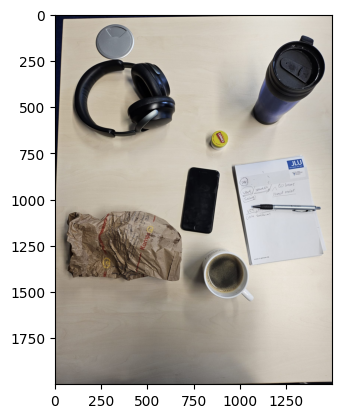

In [4]:
Datapath = "../../../Data/"
# Get an example image 
print(os.path.join(Datapath,"Img1.jpg"))
im = cv2.imread(os.path.join(Datapath,"Img1.jpg"))
plt.imshow(im[:, :, ::-1])

# Read the label list 
LabelList = pd.read_json(os.path.join(Datapath,'panoptic_coco_categories.json')) # Read the list of the labels for Image Segmentation


[02/25 14:34:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


/home/user/Detectron/lib/python3.10/site-packages/detectron2/layers/wrappers.py:127: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  x = F.conv2d(
/home/user/Detectron/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


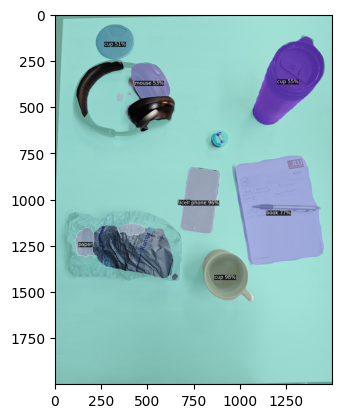

In [5]:
# Inference with a panoptic segmentation model
cfg = get_cfg() # Get the image to Detectron

################################################################
if SystemName != 'linux':
    cfg.MODEL.DEVICE = 'cpu' # This is here to make it run on mac, not needed when running it with regular gpu
################################################################

#Load the detault weigths
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")) 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

# Predict the labels 
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]

# Visualize the labels
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
plt.imshow(out.get_image()[:, :, ::-1])

In [6]:
## Access the data 
LabelPositions = torch.Tensor.cpu(panoptic_seg).numpy().astype('int') # save the pixel masks
# Get the object labels 
Objects = np.arange(0,len(segments_info),1)
Mat = np.zeros((len(segments_info),4))

for obj in Objects: 
    Mat[obj,0] = segments_info[obj].get("id")
    Mat[obj,1] = segments_info[obj].get("score")
    Mat[obj,2] = segments_info[obj].get("category_id")
    Mat[obj,3] = segments_info[obj].get("instance_id")

supercategory         electronic
color            [219, 142, 185]
isthing                        1
id                            77
name                  cell phone
Name: 67, dtype: object

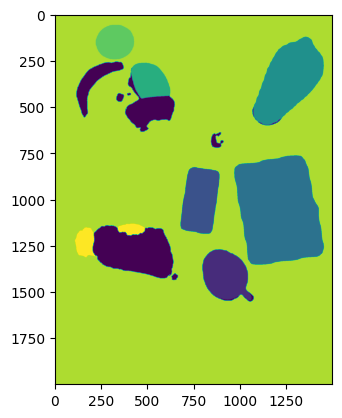

In [7]:
## Show an example how to get the category for a fixated pixel 

X = 750
Y = 1000
InnerRadius = 10 # Inner radius of the gaze overlay
OuterRadius = 30 # Outer radius of the gaze overlay

FixPix = LabelPositions[Y,X] # this is the object id someone fixated 

plt.figure
plt.imshow(LabelPositions)

if np.isnan(Mat[FixPix-1,1]):
    FixCat = int(Mat[FixPix-1,2]+79) # This is the belonging category in the list 
else:
    FixCat = int(Mat[FixPix-1,2]) # This is the belonging category in the list 
 
# Read the information from the Lookupfile 

LabelList.iloc[FixCat] # This gives you the relevant information from the list 

